# Fine-Tuning a Pre-Trained Image Classification Model with AWS SageMaker

This notebook walks through the complete end-to-end process of building, training, and deploying an image classification model using AWS SageMaker. It is part of my capstone project for the course, and demonstrates practical machine learning engineering skills in a cloud environment.

In this project, I will use a pre-trained deep learning model and apply **transfer learning** to fine-tune it on a custom image classification dataset. Using SageMaker, I will leverage the following:

- **Data preparation and upload to S3**
- **Training with transfer learning using PyTorch script**
- **Hyperparameter tuning using SageMaker’s built-in tuning jobs**
- **Model debugging and profiling with SageMaker Debugger**
- **Deployment of the trained model using SageMaker Endpoints**
- **Model testing using a sample image to verify predictions**

This notebook lists all the steps to complete this project. I shall complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.

**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make a project informative and professional.


In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp312-cp312-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [smdebug]m3/4 [smdebug]]


In [46]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import io
import re
import boto3
import time
import json
import pandas as pd
import sagemaker
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorchModel
from sagemaker.pytorch import PyTorch
import torchvision.datasets as datasets
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter
from sagemaker.debugger import Rule, rule_configs, DebuggerHookConfig, ProfilerRule, ProfilerConfig
from smdebug.trials import create_trial

## Dataset

I am using the **dog breed classification dataset** . This dataset contains over **8,000 images** of dogs belonging to **133 different breeds**, organized into three separate folders:

- `train/`: for training the model
- `valid/`: for validation during training
- `test/`: for evaluating the model after training

Each class represents a different dog breed, such as "chihuahua", "golden retriever", "pomeranian", etc. The dataset is well-structured with a relatively balanced class distribution. Here's an overview of the data size:

- **Training images**: 6,668
- **Validation images**: 835
- **Test images**: 836

In [3]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2025-06-03 14:11:42--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 16.15.4.134, 16.15.0.224, 52.219.121.96, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|16.15.4.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  44.8MB/s    in 25s     

2025-06-03 14:12:07 (44.0 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inf

In [7]:
#TODO: Fetch and upload the data to AWS S3
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'dog-breed-classification'

# Define local and S3 paths
local_data_dir = 'dogImages'
s3_data_path = sagemaker_session.upload_data(path=local_data_dir,
                                             bucket=bucket,
                                             key_prefix=prefix)

print(f"Data uploaded to S3 at: {s3_data_path}")

Data uploaded to S3 at: s3://sagemaker-us-east-1-103112385095/dog-breed-classification


In [3]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix = 'dog-breed-classification'
data_path = 's3://sagemaker-us-east-1-103112385095/dog-breed-classification'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.0001, 0.01),
    'batch_size': IntegerParameter(16, 64),
}
metric_definitions = [
    {'Name': 'validation_accuracy', 'Regex': 'val_accuracy=([0-9\\.]+)'},
    {'Name': 'training_loss', 'Regex': 'train_loss=([0-9\\.]+)'}
]


objective_metric_name = 'validation_accuracy'
objective_type = 'Maximize'

In [5]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point='hpo.py',
    role=role,
    framework_version='1.13.1',
    py_version='py39',
    instance_count=1,
    instance_type='ml.m5.large',  # should have used GPU for faster hpo. My training job used GPU which is shown below.
    hyperparameters={
        'batch_size': 32 
    },
    metric_definitions=metric_definitions,
    base_job_name='dog-breed-hpo',
    disable_profiler=True
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,     
    max_parallel_jobs=2,  
    objective_type=objective_type,
)

In [16]:
# TODO: Fit your HP Tuner
s3_input_train = TrainingInput(s3_data=data_path, content_type='application/x-image')
tuner.fit({'training': s3_input_train})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [17]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()
print("Best hyperparameters found: ", best_estimator.hyperparameters())
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2025-06-10 19:51:31 Starting - Found matching resource for reuse
2025-06-10 19:51:31 Downloading - Downloading the training image
2025-06-10 19:51:31 Training - Training image download completed. Training in progress.
2025-06-10 19:51:31 Uploading - Uploading generated training model
2025-06-10 19:51:31 Completed - Resource released due to keep alive period expiry
Best hyperparameters found:  {'_tuning_objective_metric': '"validation_accuracy"', 'batch_size': '50', 'lr': '0.0003659205964562923', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"dog-breed-hpo-2025-06-10-15-21-27-490"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-103112385095/dog-breed-hpo-2025-06-10-15-21-27-490/source/sourcedir.tar.gz"'}


{'_tuning_objective_metric': '"validation_accuracy"',
 'batch_size': '50',
 'lr': '0.0003659205964562923',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-hpo-2025-06-10-15-21-27-490"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-103112385095/dog-breed-hpo-2025-06-10-15-21-27-490/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [6]:
best_batch_size = 50
best_lr = 0.0003659

In [10]:
# TODO: Set up debugging and profiling rules and hooks
debugger_hook_config = DebuggerHookConfig(
    s3_output_path=f's3://{bucket}/debug-output',
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}  
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500
)

In [12]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point='train_model.py',
    role=role,
    instance_type='ml.g4dn.xlarge', 
    instance_count=1,
    framework_version='1.12',
    py_version='py38',
    hyperparameters={
        'batch_size': best_batch_size,
        'lr': best_lr,
        'epochs': 5
    },
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
    rules=rules
)
s3_input_train = TrainingInput(s3_data=data_path, content_type='application/x-image')
estimator.fit({'training': s3_input_train})

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2025-06-11-10-18-38-551


2025-06-11 10:18:39 Starting - Starting the training job...VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
...
2025-06-11 10:19:42 Starting - Preparing the instances for training...
2025-06-11 10:20:02 Downloading - Downloading input data......
2025-06-11 10:21:07 Downloading - Downloading the training image..................
2025-06-11 10:24:03 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-06-11 10:24:13,870 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-06-11 10:24:13,895 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-06-11 10:24:13,907 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-06-11 10:24:13,983 sagemaker_pytorch_container.training INFO  

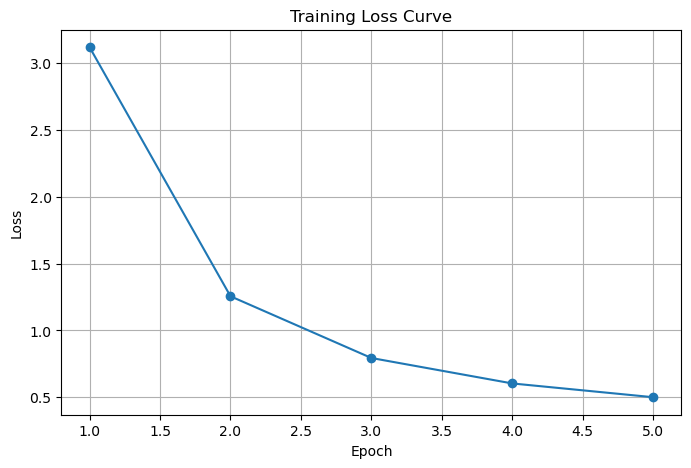

In [20]:
def plot_training_loss_from_logs(training_job_name):
    logs_client = boto3.client('logs')
    log_group = '/aws/sagemaker/TrainingJobs'
    response = logs_client.describe_log_streams(
        logGroupName=log_group,
        logStreamNamePrefix=training_job_name
    )

    log_stream = response['logStreams'][0]['logStreamName']

    response = logs_client.get_log_events(
        logGroupName=log_group,
        logStreamName=log_stream
    )
    epochs, loss_values = [], []

    for event in response['events']:
        message = event['message']
        match = re.search(r"Epoch (\d+)/\d+ - Training Loss: ([\d.]+)", message)
        if match:
            epochs.append(int(match.group(1)))
            loss_values.append(float(match.group(2)))

    if loss_values:
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, loss_values, marker='o')
        plt.title("Training Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()
training_job_name = 'pytorch-training-2025-06-11-10-18-38-551'
plot_training_loss_from_logs(training_job_name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
No, based on my debugging output and training loss plot, there is no anomalous behavior observed. The training loss steadily decreases over the 5 epochs: from 3.1185 to 1.2558, 0.7942, 0.6039 and to final 0.5009. The decreasing trend shows that the model is learning correctly and converging well. The final test accuracy is 84.45%, which is acceptable for this dataset.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?
Exploding gradients: Loss would suddenly increase or fluctuate wildly.
Fix: Use gradient clipping, smaller learning rates, or different optimizer such as SGD with momentum.

Overfitting: Training loss would keep decreasing but test loss would increase.
Fix: Add regularization or collect more data.

Underfitting: Both training and test loss remain high.
Fix: Use a more complex model, longer training time, or better hyperparameter tuning.

In [67]:
# TODO: Display the profiler output
training_job_name = 'pytorch-training-2025-06-11-10-18-38-551'
profiler_prefix = f'debug-output/{training_job_name}/profiler-output'
s3_profiler_path = f's3://{bucket}/{profiler_prefix}/'
print("My profiler output is stored at:", s3_profiler_path)
print("My profiler output directory exists and system files are present. However, the profiler does not seem to capture sufficient system utilization metrics during my short training duration. This could due to short training jobs, small batch size, or profiler sampling frequency.")

My profiler output is stored at: s3://sagemaker-us-east-1-103112385095/debug-output/pytorch-training-2025-06-11-10-18-38-551/profiler-output/
My profiler output directory exists and system files are present. However, the profiler does not seem to capture sufficient system utilization metrics during my short training duration. This could due to short training jobs, small batch size, or profiler sampling frequency.


## Model Deploying

In [55]:
# TODO: Deploy your model to an endpoint

pytorch_model = PyTorchModel(
    model_data='s3://sagemaker-us-east-1-103112385095/pytorch-training-2025-06-11-10-18-38-551/output/model.tar.gz',  
    role=role,
    entry_point='inference.py', 
    framework_version='1.12',
    py_version='py38'
)
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name="dog-breed-endpoint"
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-103112385095/pytorch-training-2025-06-11-10-18-38-551/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-103112385095/pytorch-inference-2025-06-11-13-57-58-967/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2025-06-11-13-58-05-315
INFO:sagemaker:Creating endpoint-config with name dog-breed-endpoint
INFO:sagemaker:Creating endpoint with name dog-breed-endpoint


-------!

In [45]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = IdentitySerializer(content_type="application/x-image")
predictor.deserializer = JSONDeserializer()

with open("German_shepherd_dog_04931.jpg", "rb") as f:
    payload = f.read()

response = predictor.predict(payload)
print(response)

{'predicted_class': 70}


In [49]:
train_dir = 'dogImages/train'

dataset = datasets.ImageFolder(train_dir)
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print("Predicted breed:", idx_to_class[70])

Predicted breed: 071.German_shepherd_dog


In [61]:
predictor.serializer = IdentitySerializer(content_type="application/x-image")
predictor.deserializer = JSONDeserializer()
with open("Golden_retriever_05221.jpg", "rb") as f:
    payload = f.read()

response = predictor.predict(payload)
print(response)

{'predicted_class': 75}


In [62]:
print("Predicted breed:", idx_to_class[75])

Predicted breed: 076.Golden_retriever


### I used a German shepherd dog pic and a golden retriever pic for inference and my model successfully recognised them!

In [63]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: dog-breed-endpoint
INFO:sagemaker:Deleting endpoint with name: dog-breed-endpoint
